## Financial analysis: Portfolio management

## Model training

#### Importing necessary libries

In [3]:
import sys
import os

import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import sidetable as stb
import mplfinance as mpf
from scipy.stats import zscore

import joblib
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError, MeanAbsoluteError
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 
from tensorflow.keras.metrics import Accuracy, Precision, F1Score, Recall
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

import pmdarima as pm
import ta

# sns.set_theme(style='whitegrid')
sns.set_theme('notebook')

In [4]:
import warnings 
warnings.filterwarnings("ignore")

In [5]:
sys.path.append(os.path.abspath('../scripts'))
from plotting import Plots
from utils import Utils
from logger import LOGGER
from model_utils import ModelUtil

plots = Plots()
logger = LOGGER
model_util = ModelUtil()

model_save_dir =  os.path.join(os.path.dirname(os.path.dirname(os.path.abspath('notebooks'))), 'Models')

if not os.path.exists(model_save_dir):
    os.mkdir(model_save_dir)

In [6]:
# data for tesla, Vanguard Total Bond Market ETF and S&p 500
tsla, bnd, sp500 = Utils.get_price_data()

2024-11-13 14:38 - INFO :: Fetching data took 7.84s


In [8]:
tsla = Utils.volatility_indicators(tsla)

#### Training Arima model

In [6]:
Arima_model = model_util.train_Arima_model(tsla, test_size=60, model_name = "ARIMA" ,exogenous=False)

2024-11-13 07:45 - INFO :: Training ARIMA started ....


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=15357.995, Time=1.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=15352.704, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=15353.168, Time=0.08 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=15353.201, Time=0.27 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=15351.127, Time=0.04 sec


2024-11-13 07:45 - INFO :: Training ARIMA took 2.09 seconds


 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=15354.026, Time=0.65 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 2.089 seconds


In [75]:
Arima_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2414
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -7674.564
Date:                Wed, 13 Nov 2024   AIC                          15351.127
Time:                        09:14:48   BIC                          15356.916
Sample:                             0   HQIC                         15353.232
                               - 2414                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2        33.8912      0.385     88.136      0.000      33.138      34.645
===================================================================================
Ljung-Box (L1) (Q):                   1.54   Jarque-Bera (JB):             11937.95
Prob(Q):                              0.21   Prob(JB):                         0.00
Heteroskedasticity (H):             483.94   Skew:                            -0.18
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Model summary**
- Model: SARIMAX(0, 1, 0) This model uses first-order differencing to handle non-stationarity without any AR (autoregressive) or MA (moving average) components.
- AIC (Akaike Information Criterion): 15351.127: This metric helps compare models; lower AIC values indicate better models.
- BIC (Bayesian Information Criterion): 15356.916: Similar to AIC, but penalizes for more complex models.
- sigma2: 33.8912—This represents the variance of the residuals, with lower values indicating a better fit.
- Ljung-Box (Q): 1.54 with a p-value of 0.21 This test checks for autocorrelation in residuals. The high p-value indicates no significant autocorrelation.
- Jarque-Bera (JB): 11937.95 with a p-value of 0.00. This test assesses the normality of residuals, with a low p-value indicating non-normality.
- Heteroskedasticity (H): 483.94 with a p-value of 0.00 This test indicates non-constant variance in residuals, which may signal volatility clustering.


In [74]:
joblib.dump(Arima_model, '../Models/Tsla_arima.pkl')

['../Models/Tsla_arima.pkl']

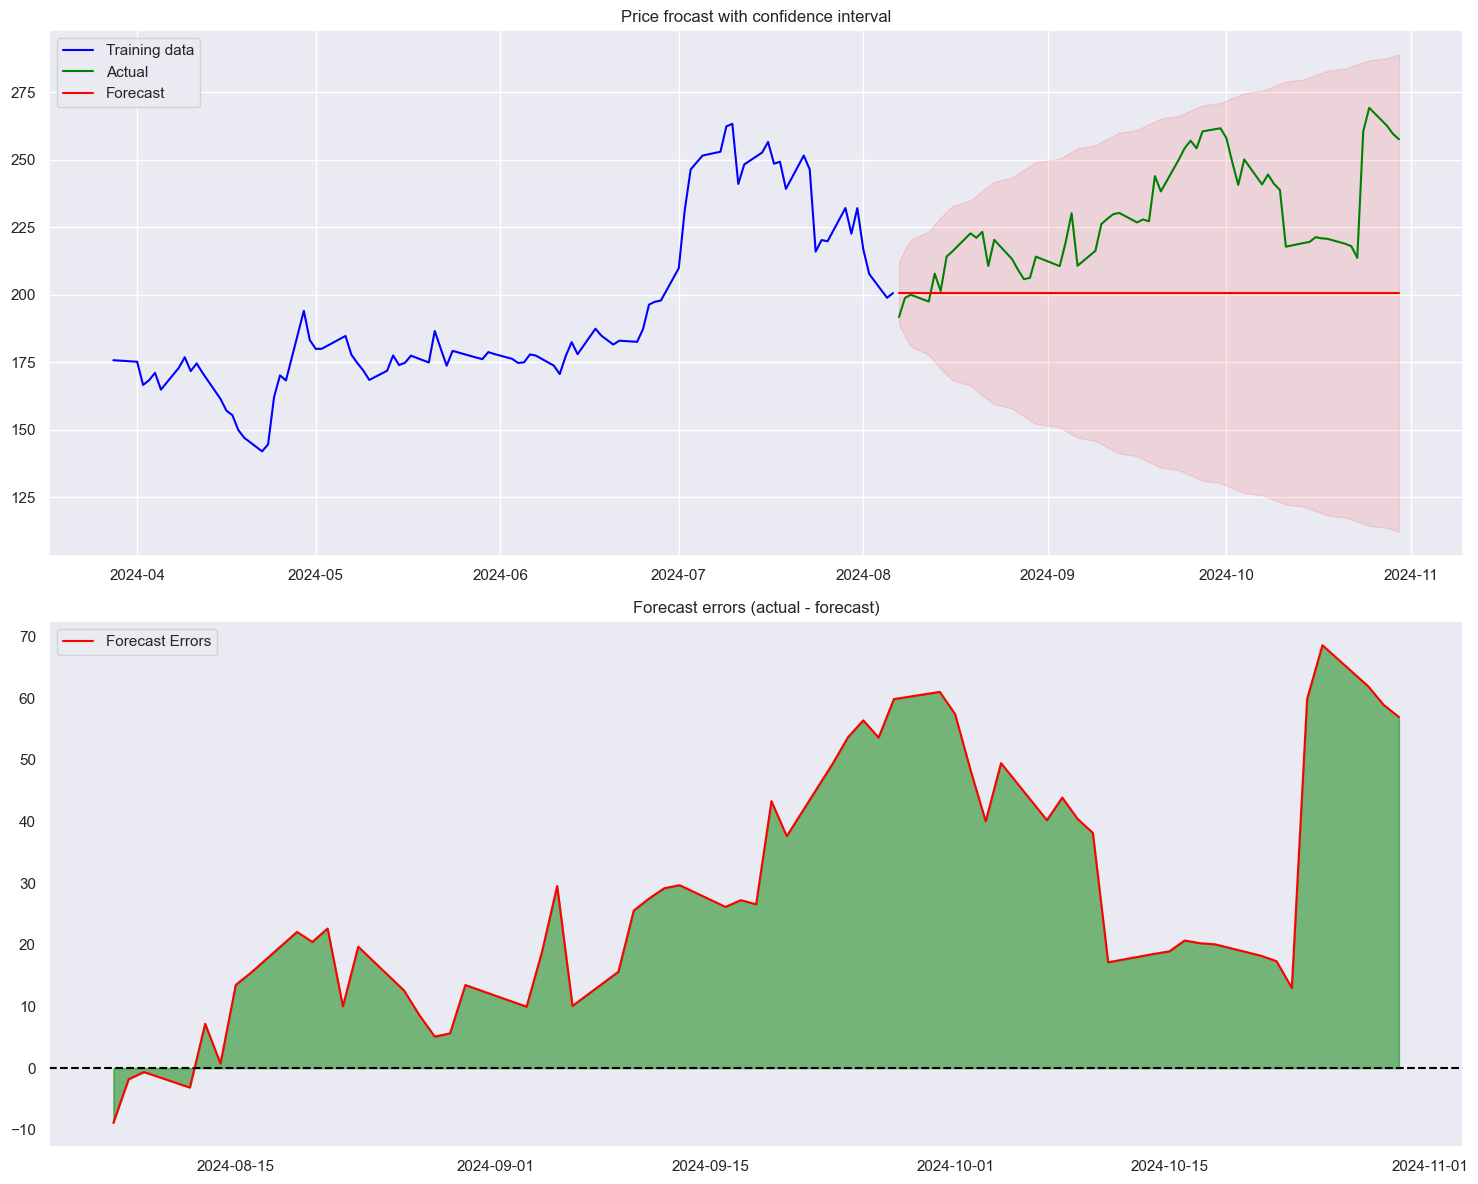

In [11]:
model_util.plot_model_forecast(Arima_model,tsla,"ARIMA", 60)

- Given the absence of volatility in the forecasted values, it prompts the question: What impact would incorporating SARIMA have on the predictive performance? 

In [12]:
model_util.model_metrics(Arima_model, "ARIMA",tsla, 60)

Mean Absolute Error (MAE): 28.500501251220705
Root Mean Squared Error (RMSE): 34.1527010690117
Mean Absolute Percentage Error (MAPE): 11.87049527529338%


### Training SARIMA model

In [13]:
Sarima_model = model_util.train_Arima_model(tsla, test_size=60, model_name = "SARIMA" ,exogenous=False)

2024-11-13 07:46 - INFO :: Training SARIMA started ....


Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=15353.927, Time=0.47 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=15352.704, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=15354.257, Time=0.61 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=15354.436, Time=0.70 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=15351.127, Time=0.02 sec
 ARIMA(0,1,0)(1,0,0)[12] intercept   : AIC=15353.782, Time=0.54 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=15350.545, Time=0.94 sec
 ARIMA(0,1,0)(2,0,1)[12] intercept   : AIC=15336.665, Time=2.71 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=15335.080, Time=1.76 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=15335.829, Time=2.18 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=15335.870, Time=2.02 sec
 ARIMA(1,1,1)(2,0,0)[12] intercept   : AIC=15336.303, Time=4.77 sec
 ARIMA(0,1,0)(2,0,0)[12]             : AIC=15333.402, Time=0.43 sec
 ARIMA(0,1,0)(1,0,0)[12]             : AIC=15352.185, Time=0.17 sec
 ARIM

2024-11-13 07:46 - INFO :: Training SARIMA took 21.96 seconds


 ARIMA(1,1,1)(2,0,0)[12]             : AIC=15334.635, Time=1.50 sec

Best model:  ARIMA(0,1,0)(2,0,0)[12]          
Total fit time: 21.813 seconds


In [76]:
Sarima_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                 2414
Model:             SARIMAX(0, 1, 0)x(2, 0, 0, 12)   Log Likelihood               -7663.701
Date:                            Wed, 13 Nov 2024   AIC                          15333.402
Time:                                    09:16:20   BIC                          15350.768
Sample:                                         0   HQIC                         15339.718
                                           - 2414                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       0.0179      0.014      1.302      0.193      -0.009       0.045
ar.S.L24       0.0938      0.011      8.343      0.000       0.072       0.116
sigma2        33.5838      0.380     88.488      0.000      32.840      34.328
===================================================================================
Ljung-Box (L1) (Q):                   1.25   Jarque-Bera (JB):             12406.30
Prob(Q):                              0.26   Prob(JB):                         0.00
Heteroskedasticity (H):             478.07   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.09
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Model summary**
- Model: SARIMAX(0, 1, 0)x(2, 0, 0, 12) This model uses seasonal components with two seasonal autoregressive terms.
- AIC: 15333.402—Slightly lower than ARIMA Model, indicating a potentially better fit.
- BIC: 15350.768—lower than ARIMA Model, reinforcing the AIC result.
- Seasonal AR Terms: L12 and L24 are included for seasonality at lag 12 and 24, respectively.
- ar.S.L12: The coefficient is 0.0179 with a p-value of 0.193, indicating it's not statistically significant.
- ar.S.L24: The coefficient is 0.0938 with a p-value of 0.000, indicating it's statistically significant.
- sigma2: 33.5838—slightly lower than in ARIMA Model, suggesting a better residual fit.
- Ljung-Box (Q): 1.25 with a p-value of 0.26 – No significant autocorrelation, similar to Arima Model .
- Jarque-Bera (JB): 12406.30 with a p-value of 0.00 – Indicates non-normality in residuals, as with Arima Model.


In [77]:
joblib.dump(Sarima_model, '../Models/Tsla_sarima.pkl')

['../Models/Tsla_sarima.pkl']

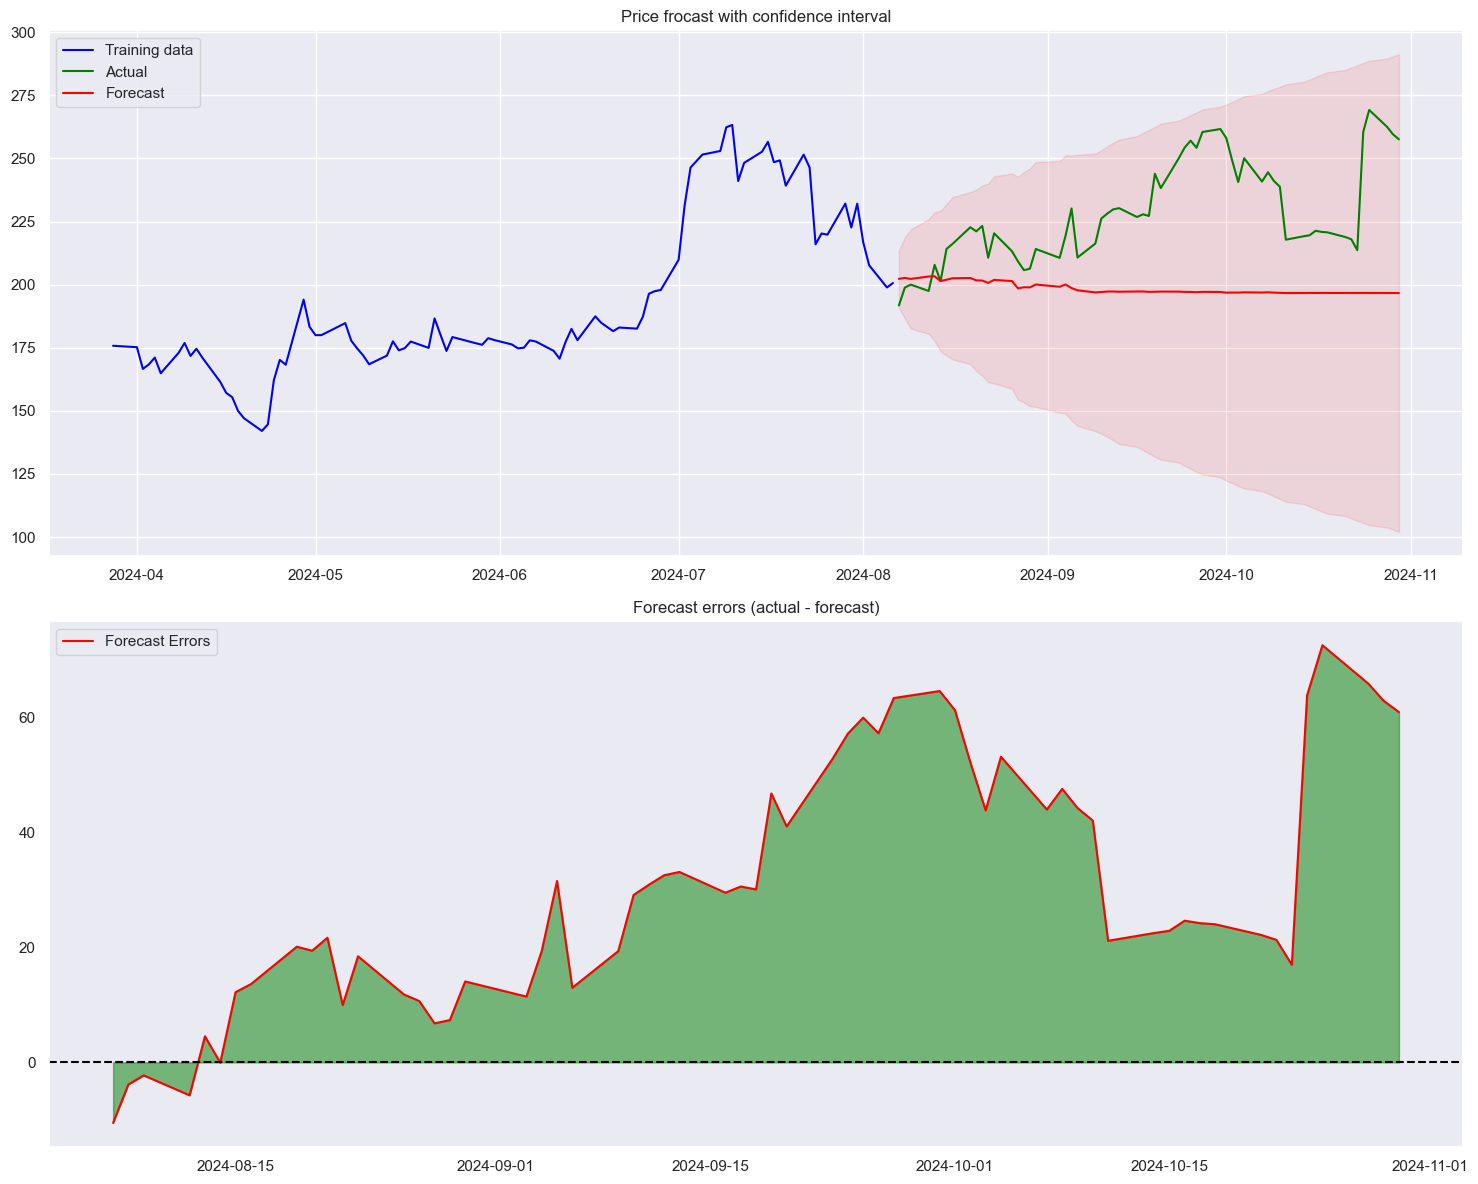

In [16]:
model_util.plot_model_forecast(Sarima_model,tsla,"SARIMA", 60)

**Observation**
- While the predicted outcomes and model performance remain consistent with ARIMA, exploring the integration of exogenous variables and transitioning to a SARIMAX model could potentially enhance the overall model performance.

In [17]:
model_util.model_metrics(Sarima_model, "SARIMA",tsla, 60)

Mean Absolute Error (MAE): 30.99317287401852
Root Mean Squared Error (RMSE): 36.81656243707454
Mean Absolute Percentage Error (MAPE): 12.932751670407786%


### Training SARIMAX model

In [18]:
Sarimax_model = model_util.train_Arima_model(tsla, test_size=60, model_name = "SARIMAX" ,exogenous=True)

2024-11-13 07:58 - INFO :: Training SARIMAX started ....


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=16919.975, Time=39.33 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=16918.241, Time=2.74 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=14298.112, Time=20.72 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=15512.487, Time=25.55 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=16918.633, Time=3.28 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=14261.365, Time=4.36 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=14340.288, Time=39.85 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=14298.773, Time=18.96 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=14262.442, Time=11.43 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=15512.528, Time=13.64 sec
 ARIMA(1,0,0)(0,0,0)[12]             : AIC=14253.915, Time=3.51 sec
 ARIMA(1,0,0)(1,0,0)[12]             : AIC=14299.352, Time=18.90 sec
 ARIMA(1,0,0)(0,0,1)[12]             : AIC=14309.044, Time=19.11 sec
 ARIMA(1,0,0)(1,0,1)[12]             : AIC=14289.261, Time=24.80

2024-11-13 08:03 - INFO :: Training SARIMAX took 268.7 seconds


 ARIMA(0,0,1)(0,0,0)[12]             : AIC=15511.495, Time=11.01 sec

Best model:  ARIMA(1,0,0)(0,0,0)[12]          
Total fit time: 268.670 seconds


In [79]:
Sarimax_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2414
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -7116.958
Date:                Wed, 13 Nov 2024   AIC                          14253.915
Time:                        09:16:52   BIC                          14311.806
Sample:                             0   HQIC                         14274.970
                               - 2414                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             3.3770      0.201     16.783      0.000       2.983       3.771
x2            -0.2409      0.039     -6.172      0.000      -0.317      -0.164
x3             2.1564      0.474      4.547      0.000       1.227       3.086
x4             8.9680      0.203     44.126      0.000       8.570       9.366
x5             0.6691      0.027     24.601      0.000       0.616       0.722
x6             0.1323      0.023      5.749      0.000       0.087       0.177
x7             0.4485      0.026     17.376      0.000       0.398       0.499
x8            -8.7826      0.197    -44.627      0.000      -9.168      -8.397
ar.L1          0.9158      0.006    155.440      0.000       0.904       0.927
sigma2        21.4261      0.280     76.389      0.000      20.876      21.976
===================================================================================
Ljung-Box (L1) (Q):                   3.40   Jarque-Bera (JB):              7362.62
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):             142.51   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Model summary**
- Model: SARIMAX(1, 0, 0): This model has an AR(1) term without differencing or MA components.
- AIC: 14253.915—significantly lower than the ARIMA and SARIMA models, suggesting a better fit.
- BIC: 14311.806—also lower than the previous models.
- AR(1) Term:
- ar.L1: The coefficient is 0.9158 with a p-value of 0.000, indicating statistical significance and strong - autoregressive behavior.
- Sigma 2: 21.4261—much lower than in the ARIMA and SARIMA models, indicating a better residual fit.
- Ljung-Box (Q): 3.40 with a p-value of 0.07 No significant autocorrelation.
- Jarque-Bera (JB): 7362.62 with a p-value of 0.00 Still non-normal residuals but lower than in the ARIMA and SARIMA models.
- Heteroskedasticity (H): 142.51 with a p-value of 0.00 Also indicates non-constant variance but lower than in the previous models.


In [78]:
joblib.dump(Sarimax_model, '../Models/Tsla_sarimax.pkl')

['../Models/Tsla_sarimax.pkl']

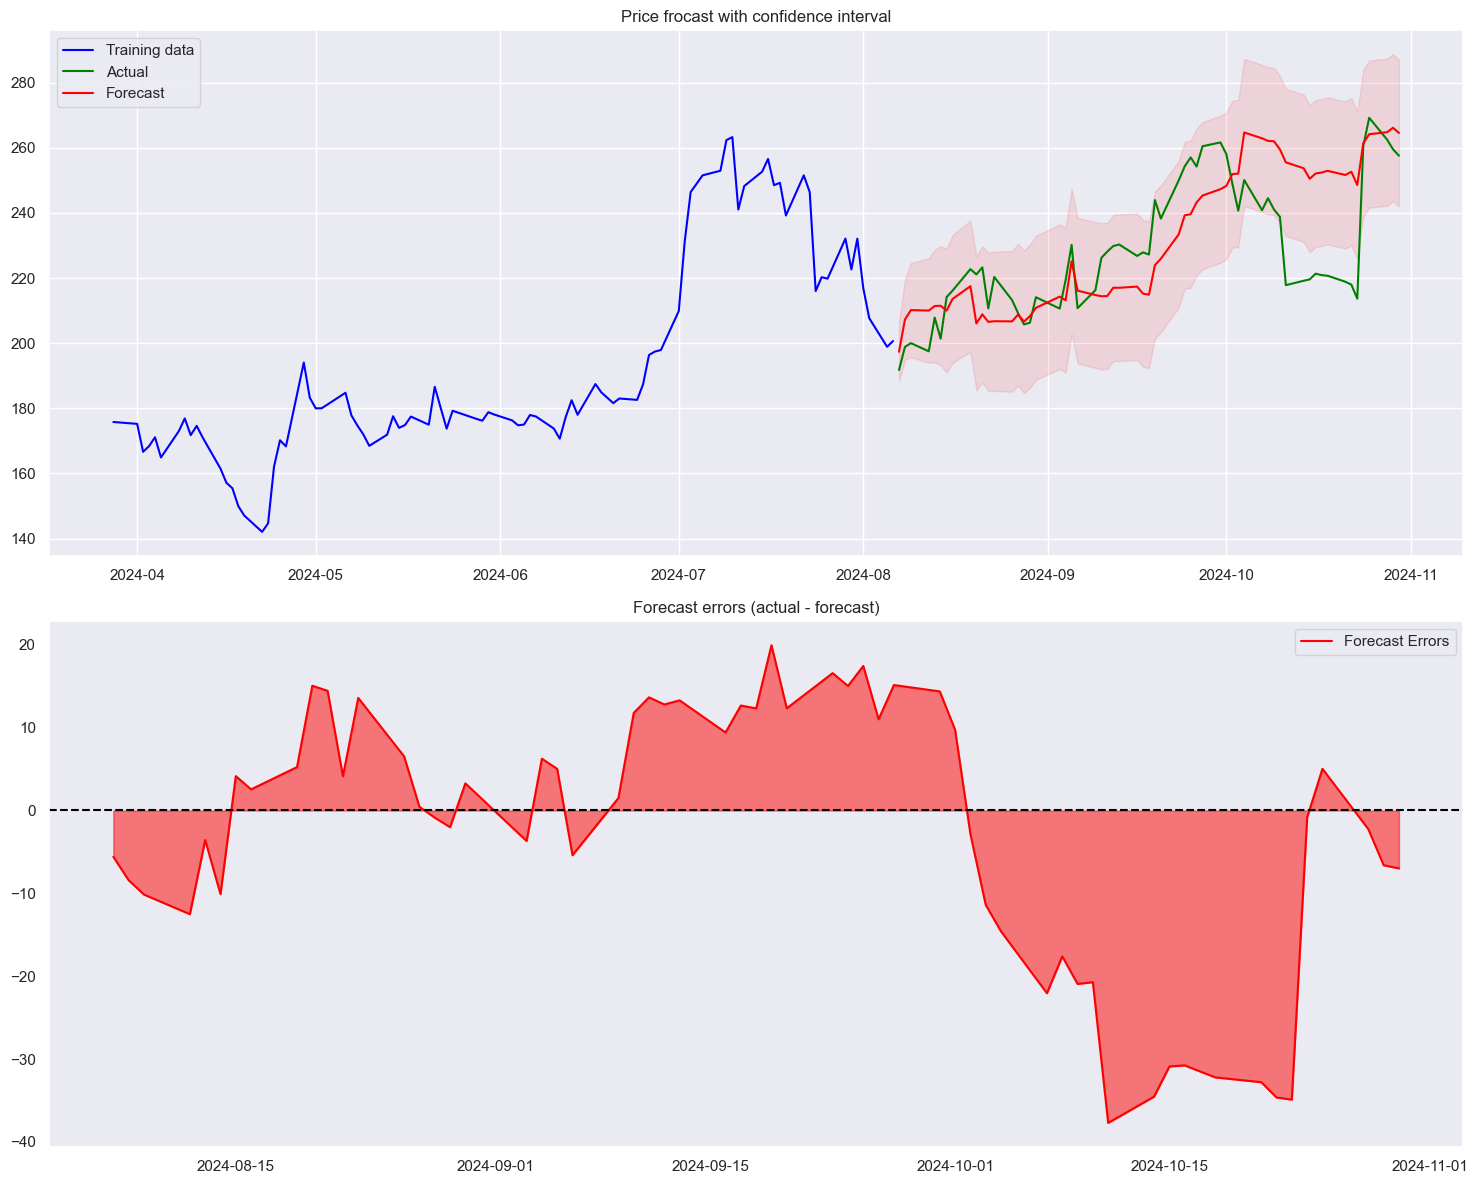

In [20]:
model_util.plot_model_forecast(Sarimax_model,tsla,"SARIMAX", 60)

**Observation**
- Unlike the other models, SARIMAX is able to capture the volatility of price while predicting

In [21]:
model_util.model_metrics(Sarimax_model, "SARIMAX",tsla, 60)

Mean Absolute Error (MAE): 13.22933118634177
Root Mean Squared Error (RMSE): 16.62273180118808
Mean Absolute Percentage Error (MAPE): 5.816556472983643%


**Observation**
- Evidently, the SARIMAX model demonstrates superior performance metrics when contrasted with the other models.

### Train LSTM Model

In [22]:
Ms = MinMaxScaler()
tsla_scaled = Ms.fit_transform(tsla)
tsla_scaled = pd.DataFrame(tsla_scaled, columns = tsla.columns)

In [ ]:
LSTM_model, history = model_util.train_lstm(tsla, 60,'LSTM', 'TSLA')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,651 (119.73 KB)

 Trainable params: 30,651 (119.73 KB)

 Non-trainable params: 0 (0.00 B)

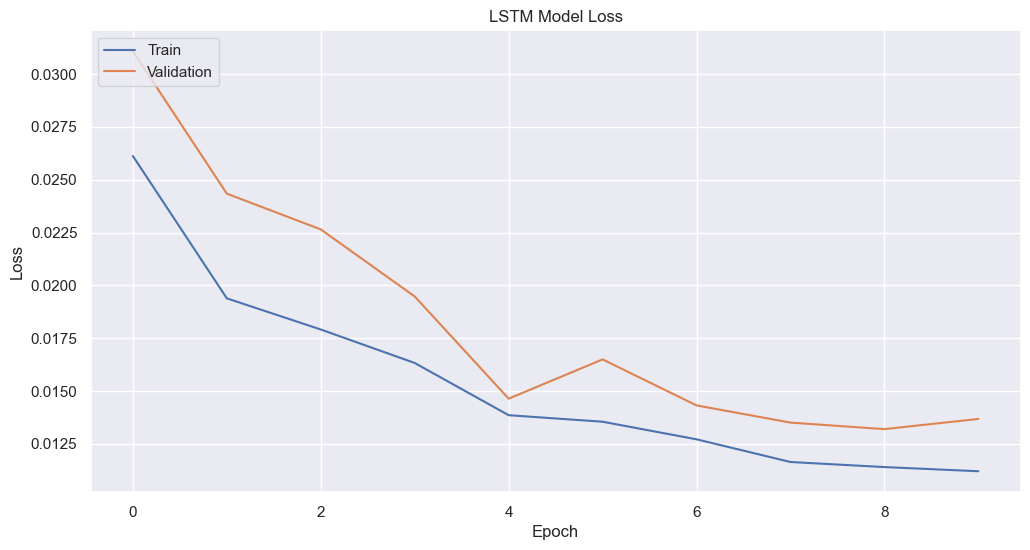

In [ ]:
model_util.plot_history(history)

**Observation**
- During the model training process, we can observe a reduction in loss with increasing epochs.

In [ ]:
from keras.models import load_model

LSTM_model.save('../Models/tsla_lstm_model.keras')